# Báo cáo đồ án môn "Khoa học dữ liệu ứng dụng"

Nhóm 11:
1. 1612355 - Lê Kinh Luân - https://github.com/kluan98
2. 1712284 - Hoàng Gia Bảo - https://github.com/hgbao8799
3. 18120052 - Lê Hạnh Linh - https://github.com/linh0303052
4. 18120182 - Lê Hồng Huy - https://github.com/lehonghuy2000
5. 1712371 - Nguyễn Văn Dưng - https://github.com/dungdev1

Link thùng chứa Github của nhóm: https://github.com/linh0303052/AplliedDSGroup11

## Mô tả bài toán

Bài toán **Santander Customer Satisfaction** được tổ chức bởi Ngân hàng Santander có thị trường là Đông Bắc Hoa Kỳ và là công ty con của tập đoàn Santander ở Tây Ban Nha.

**Link:** https://www.kaggle.com/c/santander-customer-satisfaction/overview

Vấn đề: Phân tích sự hài lòng của khách hàng là phép đo chìa khóa của thành công bởi vì các khách hàng không hài lòng sẽ có ít cơ hội mua lại lần tiếp theo và quan trọng hơn là họ sẽ nói lên sự không hài lòng của họ trên các nền tảng xã hội trước khi rời đi. Ngân hàng Santander mong muốn phát hiện sớm các khách hàng không hài lòng và có các giải pháp chủ động để cải thiện trải nghiệm, thái độ của khách hàng trước khi quá muộn.

**Input:** Dữ liệu gồm 370 thuộc tính được anonymized

**Output:** Dự đoán đây có phải là khách hàng không hài lòng với kết quả là 1 nếu *không hài lòng* hoặc 0 nếu *hài lòng*

## Giải quyết bài toán

Trong đồ án này, nhóm tìm hiểu và cài đặt lại phương pháp của nhóm **#1 Leustagos** đặt hạng 3 trên Private Leaderboard

**Github:** https://github.com/diefimov/santander_2016

**Mô tả:** Giải pháp của tác giả chủ yếu dựa trên kết hợp (ensemble) của các mô hình khác nhau vì dataset gồm rất nhiều thuộc tính nên việc dùng ensemble để tránh tình trạng overfit. Các tác giả sử dụng khá đa dạng các mô hình có tính chất làm việc tốt trên dataset bị ẩn danh hóa và dạng bảng như Random Forest, Adaboost Classifier, XGBOOST, Neural Network. Mỗi nhóm mô hình có cách tiền xử lý dữ liệu khác nhau dành cho mỗi mô hình thay vì chỉ tiền xử lý một lần đầu và dùng cho tất cả mô hình. Đây là lí do nhóm chọn giải pháp của nhóm tác giả này trong số các giải pháp top đầu.

Giải pháp này là một ensemble của 5 nhóm mô hình lớn, được tiền xử lý và chạy độc lập với nhau. Đặc điểm này cũng quy định cấu trúc của phần tiếp theo: mỗi nhóm mô hình sẽ được chia thành 2 phần lớn là phần *tiền xử lý dữ liệu* và phần *mô hình*.

### Import các thư viện cần thiết

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.model_selection import StratifiedKFold
from scipy.stats.stats import pearsonr
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer, PolynomialFeatures, MinMaxScaler
from datetime import date
from sklearn.cluster import KMeans
#dmitry models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
import xgboost as xgb
import os
import glob
import sys, getopt, re
from sklearn.metrics import auc
from IPython.display import Image

### Tải dữ liệu

In [ ]:
!wget https://github.com/linh0303052/AplliedDSGroup11/blob/main/data.tar.gz

In [ ]:
!tar -xzvf data.tar.gz

In [ ]:
train = pd.read_csv('./data/input/train.csv')
train.shape

In [ ]:
test = pd.read_csv('./data/input/test.csv')
test.shape

In [ ]:
INPUT_PATH = './data/input/'
OUTPUT_PATH = './data/output/'

### Nhóm mô hình Dmitry Efimov

* Input: Dữ liệu thô từ tập train
* Output: Dữ liệu đã được lược bỏ đi những cột không cần thiết và đã được xử lý những thuộc tính đặc biệt

#### Khám phá dữ liệu

Vì dữ liệu có đến 370 cột nên ta sẽ tìm để lược bỏ đi những cột không cần thiết.
Đầu tiên, ta tìm những cột có độ tương quan cao để tiến hành lược bớt.

In [ ]:
# Tìm các cặp cột (i, j) có độ tương quan 1.0
corr_df = train.corr()
indexes = corr_df.index
duplicates = []
for i in range(corr_df.shape[0]):
    for j in range(corr_df.shape[1]):
        if (corr_df.iloc[[i], j] == 1.0).all() and (i > j):
               duplicates.append((indexes[i], indexes[j]))
duplicates

Ta tiến hành vẽ biểu đồ phân bố dữ liệu ở một số cột để tìm phân bố bất thường.

In [ ]:
plt.hist(train['var3'])

In [ ]:
pd.unique(train['var3'])

Ta thấy ở cột **var3**, có một giá trị nhiễu là `-999999`, ta sẽ xử lý giá trị này sau.

Ở cột **var38**, ta thấy dữ liệu phân bố bất thường. Giá trị `115311.625` chiếm số lượng quá lớn.

In [ ]:
plt.hist(train['var38'], range=(5163.75, 225459.5))

In [ ]:
y = train[(train['var38'] < 117309.7074525) | (train['var38'] > 117311.91041)]['var38']
plt.hist(y, range=(5163.75, 225459.5))

Ở cột này, giá trị `0` chiếm số lượng rất lớn.

In [ ]:
plt.hist(train['imp_op_var40_comer_ult1'], range=(0, 3.57))

In [ ]:
plt.hist(train['imp_op_var40_comer_ult1'], range=(3.57, 8.237820e+03))

#### Tiền xử lý dữ liệu

Từ những khám phá ở trên, ta tiến hành tiền xử lý dữ liệu để dữ liệu được gọn gàng hơn.

Đầu tiên là xử lý những giá trị gây nhiễu ở các cột **var3**, **var38** và **imp_op_var40_comer_ult1**.

In [ ]:
#xử lý các giá trị đặc biệt, thay thế nó bằng giá trị NA (-999.0)
def process_base(train, test):
    train.loc[(train['var38']>117310.979) & (train['var38']<117310.98), 'var38'] = -999.0
    test.loc[(test['var38']>117310.979) & (test['var38']<117310.98), 'var38'] = -999.0

    train.loc[train['var3']==-999999, 'var3'] = -999.0
    test.loc[test['var3']==-999999, 'var3'] = -999.0

    for f in ['imp_op_var40_comer_ult1', 'imp_op_var40_efect_ult3', 'imp_op_var41_comer_ult3', 'imp_sal_var16_ult1']:
        train.loc[train[f]==0.0, f] = -999.0
        test.loc[test[f]==0.0, f] = -999.0

    return train, test

Sau đó ta loại bỏ các thuộc tính chỉ có 1 giá trị.

In [ ]:
def drop_sparse(train, test):
    flist = [x for x in train.columns if not x in ['ID','TARGET']]
    for f in flist:
        if len(np.unique(train[f]))<2:
            train.drop(f, axis=1, inplace=True)
            test.drop(f, axis=1, inplace=True)
    return train, test

Tiếp đến ta loại bỏ những cột có giá trị trùng nhau và chuẩn hoá các giá trị của thuộc tính.

In [ ]:
def drop_duplicated(train, test):    
    #Loại bỏ var6 vì nó trùng với var29
    flist = [x for x in train.columns if not x in ['ID','TARGET']]            
    train.drop([x for x in flist if 'var6' in x], axis=1, inplace=True)
    test.drop([x for x in flist if 'var6' in x], axis=1, inplace=True)

    #Loại bỏ các thuộc tính có chứa _0 vì nó bị trùng với cột có chứa _1 theo ngay sau
    flist = [x for x in train.columns if not x in ['ID','TARGET']]        
    flist_remove = []
    for i in range(len(flist)-1):
        v = train[flist[i]].values
        for j in range(i+1, len(flist)):
            if np.array_equal(v, train[flist[j]].values):
                if '_0' in flist[j]:
                    flist_remove.append(flist[j])
                elif  '_0' in flist[i]:
                    flist_remove.append(flist[i])
    train.drop(flist_remove, axis=1, inplace=True)
    test.drop(flist_remove, axis=1, inplace=True)

    #Loại bỏ các cột bị trùng khác
    flist_remove = ['saldo_medio_var13_medio_ult1', 'delta_imp_reemb_var13_1y3', 'delta_imp_reemb_var17_1y3', 
                       'delta_imp_reemb_var33_1y3', 'delta_imp_trasp_var17_in_1y3', 'delta_imp_trasp_var17_out_1y3',
                       'delta_imp_trasp_var33_in_1y3', 'delta_imp_trasp_var33_out_1y3']
    train.drop(flist_remove, axis=1, inplace=True)
    test.drop(flist_remove, axis=1, inplace=True)
    
    return train, test

In [ ]:
#Chuẩn hóa các giá trị thuộc tính
def normalize_features(train, test):
    flist = [x for x in train.columns if not x in ['ID','TARGET']]
    for f in flist:
        if train[f].max() == 9999999999.0:
            fmax = train.loc[train[f]<9999999999.0, f].max()
            train.loc[train[f]==9999999999.0, f] = fmax + 1

        if len(train.loc[train[f]<0, f].value_counts()) == 1:
            train.loc[train[f]<0, f] = -1.0
            test.loc[test[f]<0, f] = -1.0
            fmax = max(np.max(train[f]), np.max(test[f]))
            if fmax > 0:
                train.loc[train[f]>0, f] = 1.0*train.loc[train[f]>0, f]/fmax
                test.loc[test[f]>0, f] = 1.0*test.loc[test[f]>0, f]/fmax

        if len(train.loc[train[f]<0, f]) == 0:
            fmax = max(np.max(train[f]), np.max(test[f]))
            if fmax > 0:
                train.loc[train[f]>0, f] = 1.0*train.loc[train[f]>0, f]/fmax
                test.loc[test[f]>0, f] = 1.0*test.loc[test[f]>0, f]/fmax

        if len(train.loc[train[f]<0, f].value_counts()) > 1:
            fmax = max(np.max(train[f]), np.max(test[f]))
            if fmax > 0:
                train[f] = 1.0*train[f]/fmax
                test[f] = 1.0*test[f]/fmax

    return train, test

#### Feature Engineering

**Thuộc tính t_SNE (t-distributed Stochastic Neighbor Embedding)**

Phương pháp giảm chiều t_SNE cố gắng tìm một cách để biến đổi dữ liệu gốc vào không gian ít chiều hơn sao cho các nhóm (cluster) ở không gian gốc được bảo toàn về vị trí tương đối so với nhau trong không gian ít chiều hơn.
- Bước 1: Xác định độ tương đồng giữa từng điểm (Pi) với các điểm còn lại. Tính khoảng cách euclide giữa Pi với các điểm khác, vẽ các khoảng cách này theo đường cong phân phối chuẩn, có trung bình là 0 (khoảng cách từ Pi đến Pi). Khoảng cách từ điểm biểu diễn đến đường cong được gọi là "unscaled similarity". Scale các độ tương đồng này bằng cách chia cho tổng độ tương đồng, và tạo ra một ma trận tương đồng.

In [ ]:
Image(filename='data/image/tsne2.png', width=300)

In [ ]:
Image(filename='data/image/tsne3.png', width=200)

- Bước 2: Thả ngẫu nhiên các điểm vào không gian ít chiều hơn, lặp lại quá trình tương tự, tính khoảng cách giữa các điểm, biểu diễn phân phối nhưng lần này dùng phân phối Student (t-distribution), tạo một ma trận độ tương đồng, và di chuyển các điểm sao cho ma trận mới gần với ma trận tương đồng gốc nhất có thể. 

In [ ]:
Image(filename='data/image/tsne5.jpg', width=300)

In [ ]:
Image(filename='data/image/tsne4.png', width=200)

In [ ]:
#thuộc tính t_SNE
np.random.seed(12324)
train_tsne, test_tsne = add_features(train, test, ['SumZeros'])

flist = [x for x in train_tsne.columns if not x in ['ID','TARGET']]

X = train_tsne[flist].append(test_tsne[flist], ignore_index=True).values.astype('float64')
svd = TruncatedSVD(n_components=30)
X_svd = svd.fit_transform(X)
X_scaled = StandardScaler().fit_transform(X_svd)
feats_tsne = TSNE(n_components=2, random_state=0).fit_transform(X_scaled)
feats_tsne = pd.DataFrame(feats_tsne, columns=['tsne1', 'tsne2'])
feats_tsne['ID'] = train_tsne[['ID']].append(test_tsne[['ID']], ignore_index=True)['ID'].values
train_tsne = pd.merge(train_tsne, feats_tsne, on='ID', how='left')
test_tsne = pd.merge(test_tsne, feats_tsne, on='ID', how='left')

feat = train_tsne[['ID', 'tsne1', 'tsne2']].append(test_tsne[['ID', 'tsne1', 'tsne2']], ignore_index=True)
feat.to_csv(OUTPUT_PATH + 'tsne_feats.csv', index=False)

**Thuộc tính PCA (Principal Component Analysis)**

- Bước 1: Biến đổi giá trị các thuộc tính sao cho các thuộc tính đều có trung bình là 0.
- Bước 2: Tìm 1 đường thẳng khớp nhất với dữ liệu đường này gọi là PC1. Điều này có nghĩa là dữ liệu được trải ra trên trục PC1 nhiều hơn. 
- Bước 3: Tim đường thẳng khớp nhất với dữ liệu và vuông góc với PC1. Đây là PC2. Tương tự để tìm ra PC3,4,...
- Bước 4: Tập dữ liệu gốc sẽ được giảm chiều bằng cách tính khoảng cách từ hình chiếu của nó đến gốc tọa độ.

In [ ]:
#thuộc tính PCA
train_pca, test_pca = add_features(train, test, ['SumZeros'])

flist = [x for x in train_pca.columns if not x in ['ID','TARGET']]

pca = PCA(n_components=2)
x_train_projected = pca.fit_transform(normalize(train_pca[flist], axis=0))
x_test_projected = pca.transform(normalize(test_pca[flist], axis=0))
train_pca.insert(1, 'PCAOne', x_train_projected[:, 0])
train_pca.insert(1, 'PCATwo', x_train_projected[:, 1])
test_pca.insert(1, 'PCAOne', x_test_projected[:, 0])
test_pca.insert(1, 'PCATwo', x_test_projected[:, 1])
pca_feats = train_pca[['ID', 'PCAOne', 'PCATwo']].append(test_pca[['ID', 'PCAOne', 'PCATwo']], ignore_index=True)
pca_feats.to_csv(OUTPUT_PATH + 'dmitry_pca_feats.csv')

**Thuộc tính K-means**

Phân tập train thành n cụm bằng thuật toán K-Means, trong bài này ta cho chạy từ 2 đến 11. Mẫu i thuộc nhóm nào thì mang giá trị đó tại thuộc tính tương ứng.

In [ ]:
#thuộc tính k-means
train_k, test_k = add_features(train, test, ['SumZeros'])
train_k, test_k = normalize_features(train_k, test_k)

flist = [x for x in train_k.columns if not x in ['ID','TARGET']]

flist_kmeans = []
for ncl in range(2,11):
    cls = KMeans(n_clusters=ncl)
    cls.fit_predict(train_k[flist].values)
    train_k['kmeans_cluster'+str(ncl)] = cls.predict(train_k[flist].values)
    test_k['kmeans_cluster'+str(ncl)] = cls.predict(test_k[flist].values)
    flist_kmeans.append('kmeans_cluster'+str(ncl))

train[['ID']+flist_kmeans].append(test[['ID']+flist_kmeans], ignore_index=True).to_csv(OUTPUT_PATH + 'kmeans_feats.csv', index=False)

**Thuộc tính likelihood**

Chọn 1 hoặc 1 số thuộc tính để nhóm các mẫu. Các mẫu thuộc cùng một nhóm sẽ có cùng giá trị tại thuộc tính likelihood.

Công thức:
$$
  LL = \frac{30.y_{TB} + y_G}{30 + |G|}
$$
- yTB là trung bình TARGET của tất cả các mẫu trong tập train
- yG là trung bình TARGET của các mẫu trong nhóm G
- |G| là số phần tử thuộc nhóm G

In [ ]:
#LL = (30.yTB + yG)/(30 + |G|)
def add_likelihood_feature(fname, train_likeli, test_likeli, flist):
    tt_likeli = pd.DataFrame()
    np.random.seed(1232345)
    #Chia fold để tính toán các giá trị
    #Tập test được điền theo tập train
    skf = StratifiedKFold(train_likeli['TARGET'].values, n_folds=5, shuffle=True, random_state=21387)
    for train_index, test_index in skf:
        ids = train_likeli['ID'].values[train_index]
        train_fold = train_likeli.loc[train_likeli['ID'].isin(ids)].copy()
        test_fold = train_likeli.loc[~train_likeli['ID'].isin(ids)].copy()
        global_avg = np.mean(train_fold['TARGET'].values)
        feats_likeli = train_fold.groupby(fname)['TARGET'].agg({'sum': np.sum, 'count': len}).reset_index()
        feats_likeli[fname + '_likeli'] = (feats_likeli['sum'] + 30.0*global_avg)/(feats_likeli['count']+30.0)
        test_fold = pd.merge(test_fold, feats_likeli[[fname, fname + '_likeli']], on=fname, how='left')
        test_fold[fname + '_likeli'] = test_fold[fname + '_likeli'].fillna(global_avg)
        tt_likeli = tt_likeli.append(test_fold[['ID', fname + '_likeli']], ignore_index=True)
    train_likeli = pd.merge(train_likeli, tt_likeli, on='ID', how='left')
    
    global_avg = np.mean(train_likeli['TARGET'].values)
    feats_likeli = train_likeli.groupby(fname)['TARGET'].agg({'sum': np.sum, 'count': len}).reset_index()
    feats_likeli[fname + '_likeli'] = (feats_likeli['sum'] + 30.0*global_avg)/(feats_likeli['count']+30.0)
    test_likeli = pd.merge(test_likeli, feats_likeli[[fname, fname + '_likeli']], on=fname, how='left')
    test_likeli[fname + '_likeli'] = test_likeli[fname + '_likeli'].fillna(global_avg)
    return train_likeli, test_likeli, flist + [fname + '_likeli']

**Thêm các thuộc tính**

- Mỗi mô hình trong ensemble có thể dùng các thuộc tính khác nhau.

- Thuộc tính likelihood được thêm tại mỗi fold của mỗi epoch trong quá trình train do ta cần nhóm các mẫu để tính toán được LL, tại mỗi fold các nhóm sẽ khác nhau

In [ ]:
def add_features(train, test, features):
    flist = [x for x in train.columns if not x in ['ID','TARGET']]
    if 'SumZeros' in features:
        train.insert(1, 'SumZeros', (train[flist] == 0).astype(int).sum(axis=1))
        test.insert(1, 'SumZeros', (test[flist] == 0).astype(int).sum(axis=1))
    flist = [x for x in train.columns if not x in ['ID','TARGET']]

    if 'tsne' in features:
        tsne_feats = pd.read_csv(OUTPUT_PATH + 'features/tsne_feats.csv')
        train = pd.merge(train, tsne_feats, on='ID', how='left')
        test = pd.merge(test, tsne_feats, on='ID', how='left')

    if 'pca' in features:
        pca_feats = pd.read_csv(OUTPUT_PATH + 'features/dmitry_pca_feats.csv')
        train = pd.merge(train, pca_feats, on='ID', how='left')
        test = pd.merge(test, pca_feats, on='ID', how='left')

    if 'kmeans' in features:
        kmeans_feats = pd.read_csv(OUTPUT_PATH + 'features/kmeans_feats.csv')
        train = pd.merge(train, kmeans_feats, on='ID', how='left')
        test = pd.merge(test, kmeans_feats, on='ID', how='left')

    return train, test

#### Mô hình

#####  Adaboost classifier
Sử dụng dữ liệu gốc, Sumzeros, PCA và Likelihood

#####  XGBOOST
Sử dụng dữ liệu gốc, Sumzeros, PCA và Likelihood

**Ensemble learning**

Thay vì cố gắng xây dựng một mô hình tốt duy nhất, chúng ta sẽ xây dựng một họ các mô hình yếu hơn một chút, nhưng khi kết hợp các mô hình lại, sẽ thu được một mô hình còn vượt trội hơn cả.

Để ghép các mô hình có 3 phương pháp:  

- **Bagging**: Xây dựng một lượng lớn các model, trên những subsamples khác nhau từ tập tập dữ liệu huấn luyện. Những model này sẽ được train độc lập và song song với nhau nhưng đầu ra của chúng sẽ được trung bình cộng để cho ra kết quả cuối cùng.

- **Boosting**: Mỗi model sau sẽ học cách sửa những lỗi của model trước, tạo thành một chuỗi các model mà model sau sẽ tốt hơn model trước bởi trọng số được update qua mỗi model. Chúng ta sẽ lấy kết quả của model cuối cùng trong chuỗi model này làm kết quả trả về.

- **Stacking**: Xây dựng một số model và một meta model, các model được huấn luyện độc lập, sau đó meta model sẽ học cách kết hợp kết quả dự báo của một số mô hình một cách tốt nhất.

Tham khảo: https://svcuong.github.io/post/ensemble-learning/

**Boosting**

Chúng ta mong đợi các model yếu của thể hỗ trợ lẫn nhau, học được từ nhau để tránh đi vào các sai lầm của model trước đó. Đây là điều Bagging không làm được 

Vậy làm thể nào để hạn chế được sai lầm từ các model trước? Boosting tiến hành đánh trọng số cho các mô hình mới được thêm vào dựa trên các cách tối ưu khác nhau. Tùy theo cách đánh trọng số và cách tổng hợp lại các model, từ đó hình thành nên 2 loại Boosting:

- **Adaptive Boosting**: Mỗi learner có tiếng nói khác nhau trong việc quyết định kết quả cuối cùng. Thường mỗi learner là một cây quyết định chỉ dùng 1 thuộc tính để phân loại (stump).

In [ ]:
Image(filename='data/image/ada.png', width=600)

- **Gradient Boosting**: Mỗi mô hình mới từ từ cực tiểu hóa hàm lỗi của cả hệ thống sử dụng thuật toán Gradient Descent. Mỗi model có kích thước lớn hơn 1 stump như Adaboost.

In [ ]:
Image(filename='data/image/gradient.png', width=600)

**XGBoost (Extreme Gradient Boosting)**

Là một cài đặt của Gradient Boosting với độ chính xác cao dựa vào đạo hàm bậc 2 của hàm loss và dùng L1 và L2 regularization và tính toán song song

**Ưu điểm:**

- XGBoost có thể được sử dụng để giải quyết được tất cả các vấn đề từ hồi quy (regression), phân loại (classification), ranking và giải quyết các vấn đề do người dùng tự định nghĩa. 

- XGBoost hỗ trợ trên Windows, Linux và OS X. 

- Hỗ trợ tất cả các ngôn ngữ lập trình chính bao gồm C ++, Python, R, Java, Scala và Julia. 

- Hỗ trợ các cụm AWS, Azure và Yarn và hoạt động tốt với Flink, Spark và các hệ sinh thái khác. 

- Khả năng tận dụng tài nguyên hệ thống: tính toán song song trên CPU/GPU, tính toán phân tán trên nhiều server, tính toán khi tài nguyên bị giới hạn, cache optimization để tăng tốc training. 

- Và cuối cùng là khả năng xử lý missing data value, tiếp tục training bằng mô hình đã được build trước đó để tiết kiệm thời gian. 

In [ ]:
def train_predict_adaboost_classifier(X_train, y_train, X_test):
    clf = AdaBoostClassifier(n_estimators=300, learning_rate=0.1, random_state=32934)
    clf.fit(X_train, y_train)
    y_pred = clf.predict_proba(X_test)[:,1]
    return y_pred

In [ ]:
def train_predict_xgboost_bugged(X_train, y_train, X_test):
    param = {}
    param['objective'] = 'binary:logistic'
    param['eta'] = 0.02
    param['max_depth'] = 5
    param['eval_metric'] = 'auc'
    param['silent'] = 1
    param['nthread'] = 6
    param['gamma'] = 1.0
    param['min_child_weight'] = 5
    param['subsample'] = 0.8
    param['colsample_bytree'] = 1.0
    param['colsample_bylevel'] = 0.7
    num_round = 500

    y_pred = [0.0]*len(X_test)
    for seed in [123089, 21324, 324003, 450453, 120032]:
        param['seed'] = seed
        plst = list(param.items())
        xgmat_train = xgb.DMatrix(X_train, label=y_train, missing = -999.0)
        xgmat_test = xgb.DMatrix(X_test, missing = -999.0)
        bst = xgb.train(plst, xgmat_train, num_round)
        y_pred = y_pred + bst.predict( xgmat_test )
    y_pred = y_pred/5.0
    return y_pred

**K-nearest neighbors**

KNN là 1 thuật toán phân lớp đơn giản nhất, nó không cần học gì từ dữ liệu cả, mọi tính toán chỉ được thực hiện khi cần dự đoán 1 dữ liệu mới

Ý tưởng rất dễ hiểu và mang tính có phần là bản năng để dự đoán 1 dữ liệu mới: xét dữ liệu mới với k điểm dữ liệu gần nhất(về khoảng cách trong không gian dữ liệu), trong k láng giềng đó, lấy nhãn của nhóm chiếm đa số

KNN cũng được sử dụng để phân lớp 1 phần do tính đơn giản của nó, và xử lý tốt trên tập dữ liệu nhiễu

In [ ]:
if (number_of_folds)>0:
    mean_kapa/=number_of_folds
    print (" printing train datasets ")
    printfilcsve(np.column_stack((np.array(idstrain),np.array(train_stacker))), metafolder_train+ outset  + ".train.csv","ID,TARGET")  

stda=StandardScaler()            
X=stda.fit_transform(X)
X_test=stda.transform(X_test)        

print (" making test predictions ")        
preds=bagged_set(X, y,model, SEED, 1, X_test, update_seed=False) 
  
for pr in range (0,len(preds)):            
            test_stacker[pr]=(preds[pr]) 

preds=np.array(preds)
printfilcsve(np.column_stack((np.array(ids),np.array(test_stacker))),  metafolder_test+ outset  + ".test.csv","ID,TARGET") 

In [ ]:
def bagged_set(X_t,y_c,model, seed, estimators, xt, update_seed=True):
    
   # create array object to hold predictions 
   baggedpred=[ 0.0  for d in range(0, (xt.shape[0]))]
   #loop for as many times as we want bags
   for n in range (0, estimators):
        #shuff;e first, aids in increasing variance and forces different results
        #X_t,y_c=shuffle(Xs,ys, random_state=seed+n)
          
        if update_seed: # update seed if requested, to give a slightly different model
            model.set_params(random_state=seed + n)
        model.fit(X_t,y_c) # fit model0.0917411475506
        preds=model.predict_proba(xt)[:,1] # predict probabilities
        # update bag's array
        for j in range (0, (xt.shape[0])):           
                baggedpred[j]+=preds[j]
        #print("done bag %d mean %f  " % (n,meanthis))
   # divide with number of bags to create an average estimate            
   for j in range (0, len(baggedpred)): 
                baggedpred[j]/=float(estimators)
   # return probabilities            
   return np.array(baggedpred) 

**Neural Network**

Neural network model được xây dựng từ các layer nối tiếp nhau lên nhau.
Chúng ta sử dụng 6 layer, trong đó:
0. Input: Input dim, với 
1. Dense: fully connected layer với 120 unit (parameter của mô hình)
2. PReLu: activation function
Activation function:
- Trói buộc giá trị layer. Đầu ra của một layer được tính bằng W*x + b với W là weight, x là input của layer và b là bias. Nếu giá trị này không đươc trói buộc tới một giới hạn nhất định. Nó có thể tăng rất cao, đặc biệt trong các deep model với nhiều parameter. Điều này dẫn tới các vấn đề về tính toán mô hình.
- W*x + b là một phương trình tuyên tính, về cơ bản, nó giống với linear classifier. Và các bài toán linear không đặc biệt đủ phức tạp cho những bài toán mà mô hình deep learning phải đối mặt, vì thế chúng ta cần 1 non-linear layer (activate function).
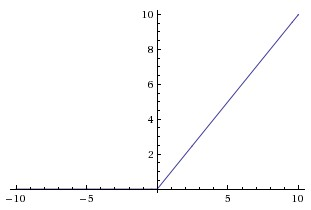
- Một chút về ReLU activation function: Rectified Linear Unit có công thức sau: f(x) = max (0, x). Nói cách khác, function này đơn giản là thresholded tại zero, layer output bằng 0 nếu x < 0 và lớn giữ nguyên nếu lớn hơn 0.
Pros: Chi phí tính toán thấp hơn Tanh/sigmoid function
Cons: Một vấn đề nó phải đối mặt là bởi vì output của nó là zero cho tất cả negative input, nó sẽ làm cho một số neuron sẽ ko được kích hoạt với bất kì data point nào nữa. Nếu điều này xảy ra, giá trị output của layer sẽ mãi mãi là zero từ thời điểm đó. (dying ReLU)
PreLu function (parametric ReLU) giải quyết vấn đề này bằng cách fix "dying ReLU" bằng cách nhân nó với một hyperparameter.
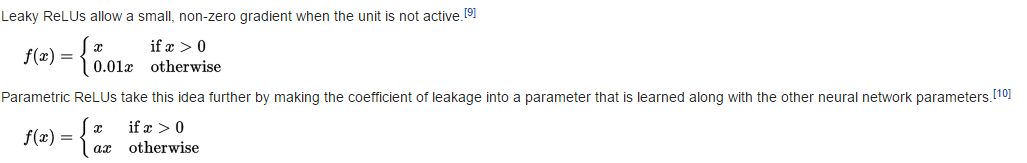
3. Batch Nomalization
- Phương pháp cho phép sử dụng learning rate cao hơn và ít phải quan tâm tới learning rate và ít phải quan tâm tới weight initialization hơn.
4. Dropout
- Phương pháp này drop unit random khỏi neural network khi training giúp giảm sự phức tạp của mô hình từ đó giúp tránh overfitting.
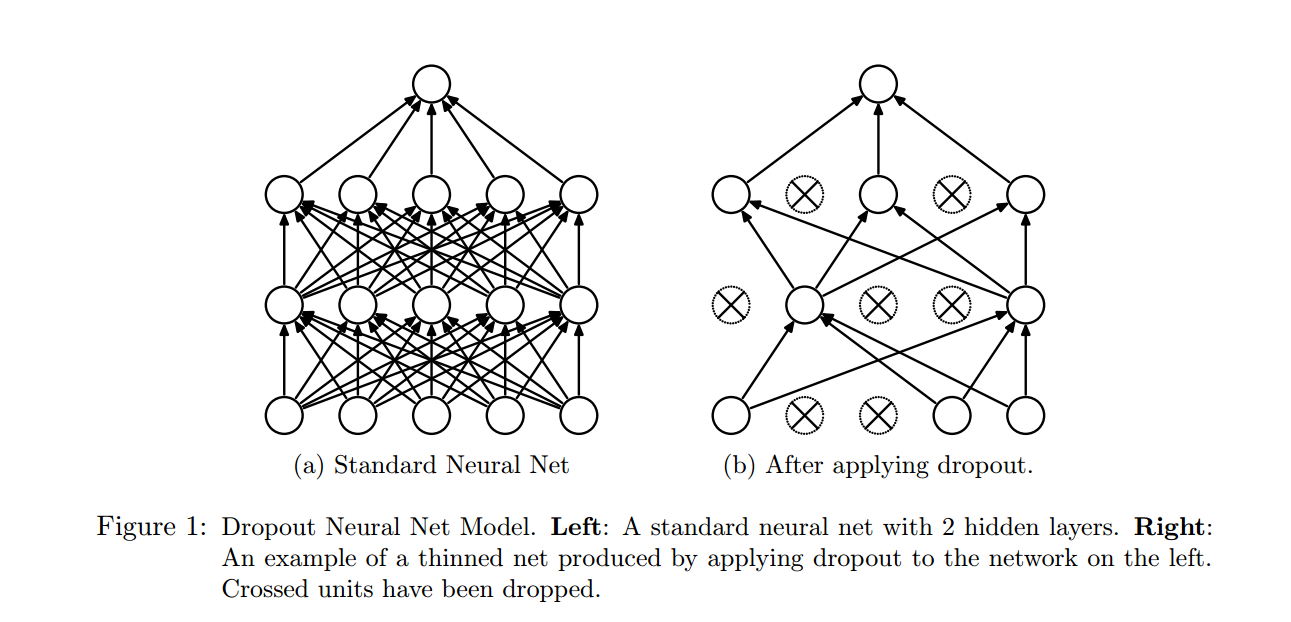
5. Dense: fully connected layer với số unit bằng output dim
6. Softmax function đưa giá trị output về xác suất
7. Binary cross-entropy loss
vì bài toán này là binary class nên ta sử dụng cross-entropy loss function
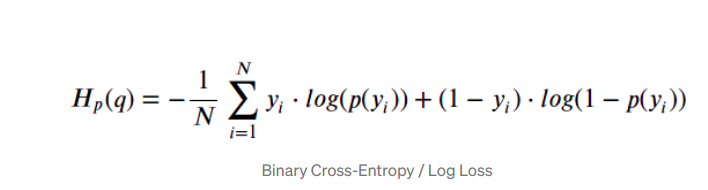


Linear classifier:
f(xi,W,b)=Wxi+b
- input data (xi,yi) as given and fixed
- we have control over the setting of the parameters W,b
- intuitively we wish that the correct class has a score that is higher than the scores of incorrect classes

Softmax classifier:
- cross-entropy-loss:
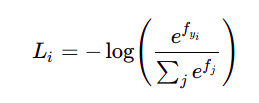
- softmax function:
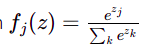


In [ ]:
def build_model(input_dim, output_dim):
    models = Sequential()

    models.add(Dense(120, input_dim=input_dim, kernel_regularizer=l2(0.00001)))
    models.add(PReLU())
    models.add(BatchNormalization())
    models.add(Dropout(0.6))
    models.add(Dense(output_dim))
    models.add(Activation('softmax'))

    opt = tf.keras.optimizers.Adagrad(learning_rate=0.0125)
    models.compile(loss='binary_crossentropy', optimizer=opt)
    return models

#####  FTRL2 (Follow the Regularized Leader)
Sử dụng dữ liệu gốc, Sumzeros và Likelihood

In [ ]:
def train_predict_ftrl(X_train, y_train, X_test):
    train_file = '../data/output-ftrl/train_ftrl.csv'
    test_file = '../data/output-ftrl/test_ftrl.csv'
    pred_file = '../data/output-ftrl/pred_ftrl.csv'

    train_csv = pd.DataFrame(X_train)
    train_csv['TARGET'] = y_train
    train_csv['ID'] = [x for x in range(1, len(train_csv)+1)]
    train_csv.to_csv(train_file, index=False)

    test_csv = pd.DataFrame(X_test)
    test_csv['ID'] = [x for x in range(1, len(test_csv)+1)]
    test_csv.to_csv(test_file, index=False)

    non_factor_cols = "''"
    non_feature_cols = "''"
    text_cols = "''"

    os.system('pypy ftrl.py' +
              ' --alpha ' + str(0.06) +
              ' --beta ' + str(1.0) +
              ' --L1 ' + str(0.01) +
              ' --L2 ' + str(1.0) +
              ' --epoch ' + str(3) +
              ' --train ' + train_file +
              ' --test ' + test_file +
              ' --submission ' + pred_file +
              ' --non_feature_cols ' + non_feature_cols +
              ' --non_factor_cols ' + non_factor_cols + 
              ' --text_cols ' + text_cols)

    y_pred = pd.read_csv(pred_file)['PRED'].values
    filelist = glob.glob("../data/output-ftrl/*.*")
    for f in filelist:
        os.remove(f)
    return y_pred

#### Chạy main

In [ ]:
#Khai báo các models và các features tương ứng
MODELS_ALL = ['ftrl2', 'rgf3', 'rgf5', 'rgf6', 'adaboost_classifier', 'xgboost']
FEATURES_ALL = [['SumZeros', 'likeli'], 
                ['SumZeros', 'pca', 'likeli'], 
                ['SumZeros', 'tsne', 'likeli'], 
                ['SumZeros', 'kmeans', 'likeli'], 
                ['SumZeros', 'pca', 'likeli'],
                ['SumZeros', 'pca', 'likeli']]

In [ ]:
preds_all = train[['ID']].append(test[['ID']], ignore_index=True).copy()
for imod in range(len(MODELS_ALL)):
    MODEL = MODELS_ALL[imod]
    FEATURES = FEATURES_ALL[imod]
    print 'Training ' + MODEL + '...'

    train = pd.read_csv(INPUT_PATH + 'train.csv')
    test = pd.read_csv(INPUT_PATH + 'test.csv')
    id_fold = pd.read_csv(INPUT_PATH+'5fold_20times.csv')
    id_fold['ID'] = train['ID'].values

    train, test = process_base(train, test)
    train, test = drop_sparse(train, test)
    train, test = drop_duplicated(train, test)
    train, test = add_features(train, test, FEATURES)

    flist = [x for x in train.columns if not x in ['ID','TARGET']]

    preds_model = pd.DataFrame()
    for it in range(1, 21):
        print 'Processing iteration ' + str(it) + '...'   
        it_id_fold = id_fold[['ID', 'set'+str(it)]]
        it_id_fold.columns = ['ID', 'FOLD']
        if 'FOLD' in train.columns:
            train.drop('FOLD', axis=1, inplace=True)
        train = pd.merge(train, it_id_fold, on='ID', how='left')
        aucs = []
        for fold in range(5):
            train_split = train.query('FOLD != @fold').copy().reset_index(drop=True)
            y_train = train_split['TARGET'].values
            val_split = train.query('FOLD == @fold').copy().reset_index(drop=True)
            test_split = val_split[['ID']+flist].append(test[['ID']+flist], ignore_index=True)
            ids_val = val_split['ID'].values

            if 'likeli' in FEATURES:
                train_split, test_split, flist1 = add_likelihood_feature('saldo_var13', train_split, test_split, flist)
            else:
                flist1 = flist
            
            X_train = train_split[flist1].values
            y_train = train_split['TARGET'].values
            X_test = test_split[flist1].values

            if 'rgf' in MODEL:
                y_pred = train_predict_rgf(X_train, y_train, X_test)

            if MODEL == 'extra_trees':
                y_pred = train_predict_extra_trees(X_train, y_train, X_test)

            if MODEL == 'xgboost':
                y_pred = train_predict_xgboost_bugged(X_train, y_train, X_test)            

            if MODEL == 'adaboost_classifier':
                y_pred = train_predict_adaboost_classifier(X_train, y_train, X_test)

            if 'ftrl' in MODEL:
                y_pred = train_predict_ftrl(X_train, y_train, X_test)
            
            preds = pd.DataFrame()
            preds['ID'] = test_split['ID'].values
            preds['FOLD'] = fold
            preds['ITER'] = it
            preds[MODEL] = y_pred
            preds_model = preds_model.append(preds, ignore_index=True)

            preds = preds.loc[preds['ID'].isin(ids_val)].copy()
            preds = pd.merge(preds, train[['ID', 'TARGET']], on='ID', how='left')

            fold_auc = auc(preds['TARGET'], preds[MODEL])
            aucs.append(fold_auc)
        print np.mean(aucs), np.std(aucs)

    preds_model.loc[preds_model[MODEL]<0, MODEL] = 0.0
    preds_model.loc[preds_model[MODEL]>1, MODEL] = 1.0
    preds_model = preds_model.groupby(['ID', 'ITER'])[MODEL].mean().reset_index()
    for it in range(1, 21):
        preds_model.loc[preds_model['ITER']==it, MODEL] = preds_model.loc[preds_model['ITER']==it, MODEL].rank()
    preds_model = preds_model.groupby('ID')[MODEL].mean().reset_index()
    preds_model.columns = ['ID', 'dmitry_'+MODEL]
    preds_all = pd.merge(preds_all, preds_model, on='ID', how='left')
    preds_all.to_csv('all_models_temp.csv', index=False)

In [ ]:
preds_train = pd.merge(train[['ID']], preds_all, on='ID', how='left')
preds_train.to_csv(OUTPUT_PATH + 'train/' + 'dmitry_train.csv', index=False)
preds_test = pd.merge(test[['ID']], preds_all, on='ID', how='left')
preds_test.to_csv(OUTPUT_PATH + 'test/' + 'dmitry_test.csv', index=False)
print "Done training!"

#### Kết quả

AUC: 0.8275 
Hạng 58 trên private leaderboard

## Phương pháp tiền xử lý dữ liệu mới

Đánh giá độ quan trọng của thuộc tính bằng Decision Tree Feature Importance

Phương pháp dùng để chọn ra splitting attribute chia data partition D thành những individual classes. Nếu chúng ta chia D thành những partitions theo splitting attribute, lý tưởng là mỗi partition đó có độ thuần khiết cao nhất có thể (ex: tất cả tuples thuộc về 1 partition cùng 1 class). Có thể hiểu Attribute selection measure là splitting rules bởi vì chúng xác định cách mà những tuples tại một node được chia.